In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [0]:
data = pd.read_csv("AB_NYC_2019.csv")

In [0]:
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

Les variables qui peuvent nous intéresser 

# Preprocessing du dataset

## Drop des colonnes non utiles

Les informations sur le propriétaire ne nous intéressent pas dans cette étude, de même que la description du bien


In [0]:
data.drop(columns=["name", "host_id", "host_name"], inplace=True)

## Etude de répartition des prix

In [0]:
data.price.describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

Waouh ! On a des locations gratuites et d'autres qui valent 10,000 dollars la nuit ! Celles à 10,000 dollars peuvent être légitimes, en revanche on va supprimer les chambres à 0 dollar car cela ne semble pas correct ...

In [0]:
data = data[data.price > 0]

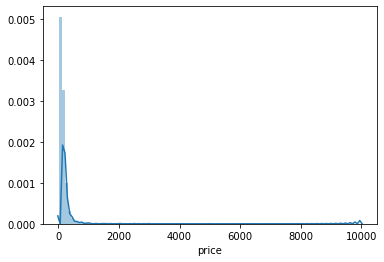

In [0]:
sns.distplot(data["price"], bins=100) # On affiche l'histogramme des prix

Bon c'est pas super centré et visible, on va regarder la répartition du logarithme des prix

In [0]:
logprice = np.log(data.price)

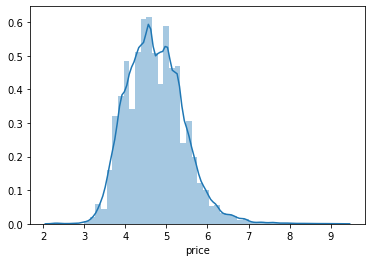

In [0]:
sns.distplot(logprice)

Là c'est bien mieux ! On voit que les logarithmes des prix des logements suivent une loi normale dont on va trouver les paramètres

Moyenne de logprice : 4.727030887745868
Ecart-type de logprice : 0.6982248633709675


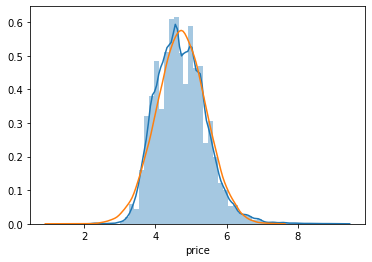

In [0]:
print("Moyenne de logprice : " + str(logprice.mean()))
print("Ecart-type de logprice : " + str(logprice.std()))

sns.distplot(logprice)
sns.distplot(np.random.normal(logprice.mean(), logprice.std(), 40000), hist=False)

## Etude et encoding de Room Type

On a voulu se pencher sur l'influence du type de chambre sur le prix pour tenter de caractériser numériquement cette variable 

In [0]:
data = pd.get_dummies(data, columns=["room_type"])
# Un one-hot-encoding classique pour pouvoir calculer les corrélations

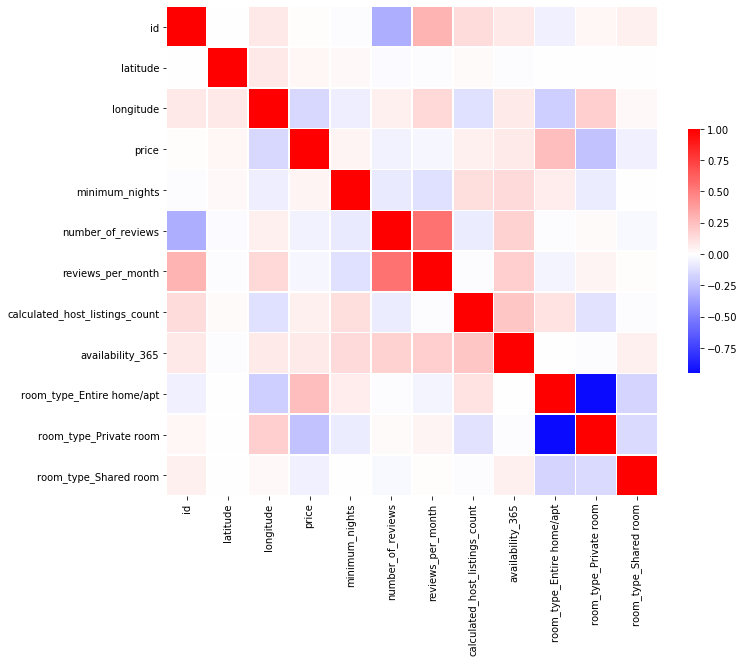

In [0]:
# Notre matrice de corrélation
corr = data.corr()

# Le graphe
f, ax = plt.subplots(figsize=(11, 9))

# Un peu de couleur
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# L'affichage 
sns.heatmap(corr, cmap="bwr", vmax=1, center=0, linewidths=.5, cbar_kws={"shrink": .5})

On voit donc que le type de bien a une influence sur son prix. Un bien de type Entire home/apt aura tendance à être plus cher qu'un bien similaire de type Private Room ou Shared Room. 

In [0]:
dataRoomType1 = data[data["room_type_Entire home/apt"] == 1]
dataRoomType2 = data[data["room_type_Private room"] == 1]
dataRoomType3 = data[data["room_type_Shared room"] == 1]

roomType1logPrice = np.log(dataRoomType1.price)
roomType2logPrice = np.log(dataRoomType2.price)
roomType3logPrice = np.log(dataRoomType3.price)

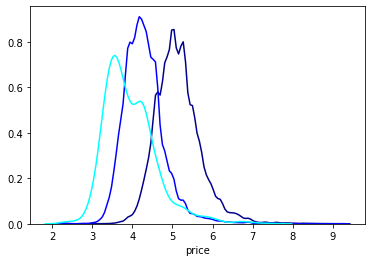

In [0]:
sns.distplot(roomType1logPrice, hist=False, color="darkblue")
sns.distplot(roomType2logPrice, hist=False, color="blue")
sns.distplot(roomType3logPrice, hist=False, color="cyan")

On se rend compte que les prix ne suivent pas la même répartition selon le type de location. Cependant on ne saura pas en tirer profit pour encoder cette variable de façon avantageuse.
On va conserver le One-Hot encoding 

## Etude et encoding de neighbourhood

La variable catégorielle neighbourhood sera encodée par one-hot encoding 

In [0]:
data = pd.get_dummies(data, columns=["neighbourhood"])

## Préparation des jeux d'entraînement et de test

In [0]:
data.columns

In [0]:
response = "price"
features = ["latitude", "longitude", "minimum_nights", "number_of_reviews"] + [col for col in data.columns[9:]]

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(
    data[features],
    data[response],
    test_size = 0.3
)

# Entraînement pour la prédiction du prix

In [0]:
def evaluer(model):
  return np.round(
      np.sqrt(mean_squared_error(
          Y_test,
          model.predict(X_test)
          )
      ),
      2
  )

## 1er entraînement : Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, Y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
lr.score(X_test, Y_test)

-117187923062026.73

In [0]:
evaluer(lr)

2639438000.57

Et là, c'est le bug ... Pour une raison que l'on a pu déterminer avec l'analyse en R du dataset, on se rend compte que nos variable ne sont pas du tout corrélées linéairement ! Une regression linéaire ne donnera pas de résultats satisfaisants 

## 2ème entraînement : Ridge regression

In [0]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(cv=5)
ridge.fit(X_train, Y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [0]:
ridge.score(X_test, Y_test)

0.1184312776557711

In [0]:
evaluer(ridge)

228.93

Ok on s'approche un peu ! L'erreur quadratique moyenne est entre 190 et 230 sur les tests différents que nous avons menés.

## 3ème entraînement : Lasso regression

In [0]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(eps=0.0001, precompute=True, n_jobs=-1)
lasso.fit(X_train, Y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.0001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=-1, normalize=False, positive=False,
        precompute=True, random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [0]:
lasso.score(X_test, Y_test)

0.1108465169011752

In [0]:
evaluer(lasso)

229.91

Pas bien mieux que le Ridge 

## 4ème entraînement : XGBoost

In [0]:
import xgboost as xgb

In [0]:
params = {
    'n_estimators': 2000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'learning_rate': 0.005,
    'n_jobs' : 4,
    'objective' : 'reg:squarederror'
}

gbm = xgb.XGBRegressor(**params)
gbm.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.005, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=4, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)

In [0]:
gbm.score(X_test, Y_test)

0.15973072504774988

In [0]:
evaluer(gbm)

223.5

Le XGBoost est sensiblement meilleur mais à ce niveau, pas de quoi s'enflammer

## Utilisation de GridSearch pour optimiser le XGBoost

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
params = {
    'n_estimators': [1000, 2000, 4000],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'learning_rate': [0.005, 0.01],
    'max_depth':[3, 5, 7]
}

In [0]:
search = GridSearchCV(
    estimator=xgb.XGBRegressor(), 
    param_grid=params, 
    cv=2, 
    n_jobs=8, 
    verbose=5
)

In [0]:
# search.fir(X_train, Y_train)

In [0]:
# search.best_estimator_

In [0]:
# evaluer(search)

Bon le GridSearch c'est intéressant mais il faut une bonne capacité de calcul et la possibilité de paralléliser les tâches ... Google n'a pas aimé qu'on lui demande 32 coeurs et nous a arrêté le calcul après 230 minutes ... Pas cool mais on n'aurait sans doute pas eu beaucoup mieux !

## Essai en recherchant les k plus proches voisins


Notre idée ici est de prédire le prix de location d'un appartement en recherchant une moyenne des prix sur les appartements de type similaires dans une zone géographique proche.

On va donc se focaliser sur le type des appartements et considérer comme distance la distance géographique définie par la latitude et la longitude des biens.

In [0]:
from sklearn.neighbors import KNeighborsRegressor

In [0]:
knn = KNeighborsRegressor(
    n_neighbors=65,
    weights="distance"
)

In [0]:
knn.fit(X_train, Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=65, p=2,
                    weights='distance')

In [0]:
knn.score(X_test, Y_test)

0.07951248595579731

In [0]:
evaluer(knn)

233.93

On va essayer plusieurs valeurs de n dans le KNN pour déterminer le meilleur (65 ici dans l'absolu mais le coude se situe plus vers 22)

In [0]:
results = []
for n in range(5,150,2) :
  knn_for = KNeighborsRegressor(
    n_neighbors=n,
    weights="distance"
    )
  knn_for.fit(X_train, Y_train)
  results.append((n, knn_for.score(X_test, Y_test)))

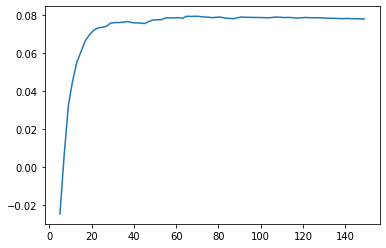

In [0]:
L = list(zip(*results))

sns.lineplot(L[0],L[1])

Bon ce n'est pas mieux que le RidgeRegression ou le XGBoost



In [0]:
 features_alt = ["latitude", "longitude"] + [col for col in data.columns if col.startswith("room")]


 X_train_alt, X_test_alt, Y_train_alt, Y_test_alt = train_test_split(
    data[features_alt],
    data[response],
    test_size = 0.3
)

In [0]:
knn_alt = KNeighborsRegressor(
    n_neighbors=65,
    weights="distance"
)

knn_alt.fit(X_train_alt, Y_train_alt)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=65, p=2,
                    weights='distance')

In [0]:
knn_alt.score(X_test_alt, Y_test_alt)

0.10492981248909117

In [0]:
np.round(
      np.sqrt(mean_squared_error(
          Y_test_alt,
          knn_alt.predict(X_test_alt)
          )
      ),
      2
  )

202.88

# Visualisation des erreurs

In [0]:
def squarederror(predictions, valeurs) : return np.sqrt(np.abs(predictions**2 - valeurs**2))

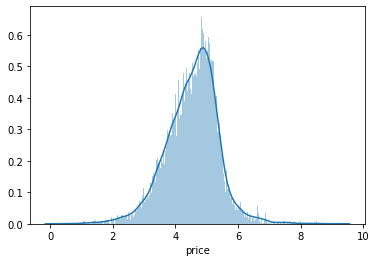

In [0]:
# Pour le Ridge
sns.distplot(np.log(squarederror(ridge.predict(X_test), Y_test)), bins=500)

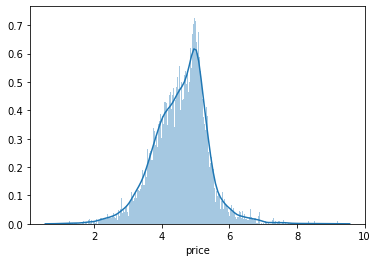

In [0]:
# Pour le Lasso
sns.distplot(np.log(squarederror(lasso.predict(X_test), Y_test)), bins=500)

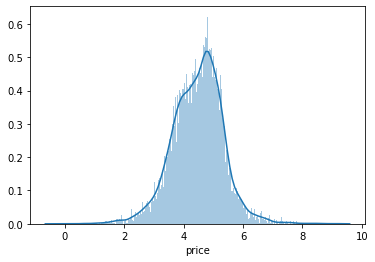

In [0]:
#Pour le XGBoost
sns.distplot(np.log(squarederror(gbm.predict(X_test), Y_test)), bins=500)

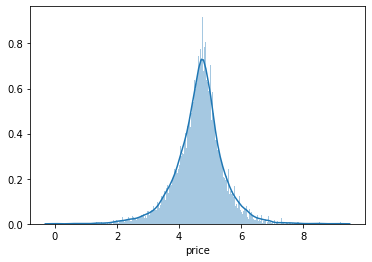

In [0]:
# Pour le knn
sns.distplot(np.log(squarederror(knn.predict(X_test), Y_test)), bins=500)